# Persistence and Performance

## Why Data Persistence Matters

- **Business Continuity**: Ensures your data survives system restarts
- **Cost Effectiveness**: Avoid recomputing embeddings
- **Horizontal Scaling**: Enables distributed architectures

## Setup and Initialization

In [1]:
# Install the required packages
!uv pip install accelerate==1.6.0 sentence-transformers==4.0.2

Using Python 3.12.9 environment at: /workspaces/fundamentals-of-ai-engineering-principles-and-practical-applications-6026542/.venv
Audited 2 packages in 66ms


In [3]:
# Import required libraries
import chromadb
from chromadb.utils import embedding_functions
import time
import numpy as np
import os

print("\n=== PERSISTENT STORAGE ===")
# Set up the storage path with error handling
db_path = "../scratch/chroma_db"
os.makedirs(db_path, exist_ok=True)  # Create directory if it doesn't exist

# Initialize a persistent client that stores data on disk
print("Creating a persistent Chroma client...")
client = chromadb.PersistentClient(path=db_path)

# Create an embedding function using the SentenceTransformer model
# all-MiniLM-L6-v2 is a good balance of speed and quality for most use cases
print("Setting up embedding function...")
embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2"
)


=== PERSISTENT STORAGE ===
Creating a persistent Chroma client...
Setting up embedding function...


In [4]:
# Helper function to display query results in a readable format
def display_results(results):
    print("\nResults:")
    for i, (doc, doc_id, metadata, distance) in enumerate(zip(
        results['documents'][0],
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    )):
        print(f"{i+1}. Document: {doc}")
        print(f"   ID: {doc_id}")
        print(f"   Metadata: {metadata}")
        print(f"   Distance: {distance}")
        print()

## Creating and Using a Persistent Collection

Below we create a persistent collection and add sample documents to demonstrate basic operations.

In [5]:
# Create a new collection with our embedding function
print("Creating a persistent collection...")
persistent_collection = client.create_collection(
    name="persistent_docs",
    embedding_function=embedding_function
)

# Sample documents about data persistence
documents = [
    "This is a document that will be stored persistently",
    "Vector databases need to persist data for production use",
    "Data persistence ensures your embeddings survive restarts"
]

# Add documents with unique IDs
ids = ["pdoc1", "pdoc2", "pdoc3"]
persistent_collection.add(
    documents=documents,
    ids=ids
)

# Query the collection to verify it works
results = persistent_collection.query(
    query_texts=["persistent data storage"],
    n_results=1
)

display_results(results)

Creating a persistent collection...

Results:
1. Document: This is a document that will be stored persistently
   ID: pdoc1
   Metadata: None
   Distance: 0.7845402441433474



## Why Performance Matters

When working with vector databases in production, performance becomes critical for several reasons:

- **User Experience**: Slow query responses lead to poor user experiences
- **Resource Utilization**: Inefficient operations consume excessive computational resources
- **Scaling Challenges**: Performance problems compound as your data grows
- **Cost Implications**: In cloud environments, inefficient operations directly impact costs

Below we'll conduct a simple performance test with a larger dataset.

In [6]:
print("\n=== PERFORMANCE CONSIDERATIONS ===")

# Create a separate collection for performance testing
collection = client.create_collection(
    name="performance_test",
    embedding_function=embedding_function
)

# Generate 1000 synthetic documents using random combinations of AI-related words
print("Generating synthetic documents for performance testing...")
words = ["AI", "machine", "learning", "vector", "database", "embedding", "neural",
         "network", "transformer", "data", "science", "engineering", "model",
         "algorithm", "optimization", "natural", "language", "processing"]

num_docs = 1000
documents = []

for i in range(num_docs):
    # Create a random document of 10-20 words
    doc_len = np.random.randint(10, 20)
    doc = " ".join(np.random.choice(words, size=doc_len))
    documents.append(doc)

ids = [f"perf_doc_{i}" for i in range(num_docs)]

# Measure time to add documents in batches
print(f"Adding {num_docs} documents to collection...")
start_time = time.time()

# Process in batches of 100 for better performance
batch_size = 100
for i in range(0, num_docs, batch_size):
    end_idx = min(i + batch_size, num_docs)
    collection.add(
        documents=documents[i:end_idx],
        ids=ids[i:end_idx]
    )

add_time = time.time() - start_time
print(f"Time to add {num_docs} documents: {add_time:.2f} seconds")

# Measure query performance across multiple queries
print("\nTesting query performance...")
query_times = []
num_queries = 5

for i in range(num_queries):
    # Generate a random 5-word query
    query = " ".join(np.random.choice(words, size=5))
    start_time = time.time()
    collection.query(
        query_texts=[query],
        n_results=10
    )
    query_time = time.time() - start_time
    query_times.append(query_time)
    print(f"Query {i+1}: {query_time:.4f} seconds")

print(f"Average query time: {np.mean(query_times):.4f} seconds")


=== PERFORMANCE CONSIDERATIONS ===
Generating synthetic documents for performance testing...
Adding 1000 documents to collection...
Time to add 1000 documents: 4.57 seconds

Testing query performance...
Query 1: 0.0148 seconds
Query 2: 0.0134 seconds
Query 3: 0.0131 seconds
Query 4: 0.0135 seconds
Query 5: 0.0141 seconds
Average query time: 0.0138 seconds


## Performance Test Results

Let's visualize the query performance results with a chart:

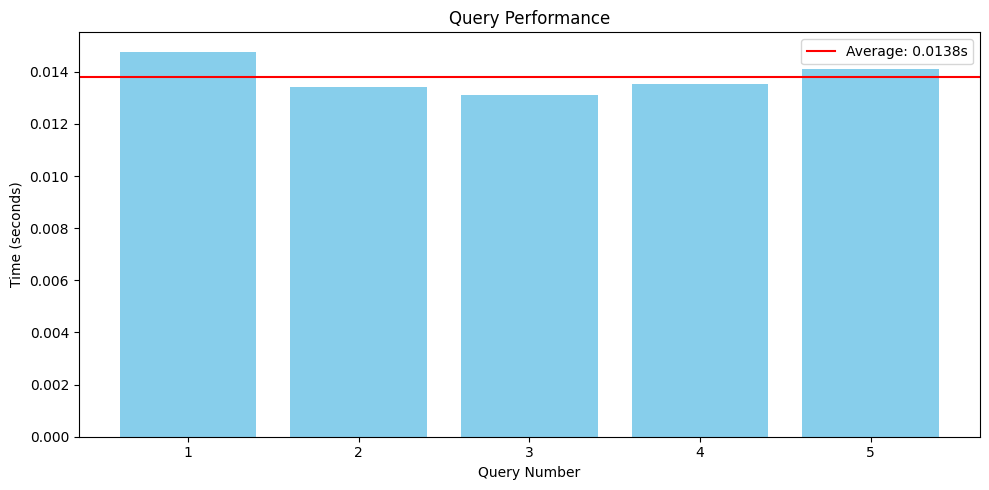

In [7]:
# Visualizing query performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(1, num_queries + 1), query_times, color='skyblue')
plt.axhline(y=np.mean(query_times), color='r', linestyle='-', label=f'Average: {np.mean(query_times):.4f}s')
plt.xlabel('Query Number')
plt.ylabel('Time (seconds)')
plt.title('Query Performance')
plt.legend()
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Persistence**: ChromaDB's PersistentClient provides an easy way to store vector embeddings on disk
2. **Performance**: 
   - Batch processing improves throughput when adding documents
   - Query performance remains fast even with 1000 documents (~13ms)
   - Consider monitoring performance as your collection size grows
3. **Production Readiness**:
   - Use persistent storage in production environments
   - Implement proper error handling
   - Consider scaling strategies for larger datasets

## Best Practices for Production Use

1. **Indexing Strategy**: For larger collections (>100K documents), consider using HNSW indexing (see next chapter for info).
   ```python
   collection = client.create_collection(
       name="large_collection",
       metadata={"hnsw:space": "cosine", "hnsw:construction_ef": 100, "hnsw:search_ef": 50}
   )
   ```

2. **Metadata Usage**: Enhance documents with metadata for filtering
   ```python
   collection.add(
       documents=["Document text..."],
       ids=["unique_id"],
       metadatas=[{"category": "finance", "date": "2025-04-01"}]
   )
   ```

3. **Hybrid Search**: Combine vector search with metadata filtering
   ```python
   results = collection.query(
       query_texts=["finance report"],
       where={"category": "finance"},
       n_results=5
   )
   ```

4. **Regular Backups**: Implement a backup strategy for your database directory